# Rozhodovací stromy: učení se z dat
  
  * V tomto notebooku byste se měli naučit, jak vytvořit (naučit) model dat ve formě rozhodovacího stromu.
  * Ukážeme si typický způsob, jak se toto dělá a představíme si i základní API knihovny `sklearn`.
  * Začneme s daty a skončíme s naučeným modelem, o kterém budeme tušit, jak je dobrý.

In [2]:
import math
import pandas as pd
import numpy as np
from IPython.display import display

## Data: základní přehled

  * Použijeme balíček `pandas` k nahrání dat a jejich základnímu prozkoumání.
  * Data jsme stáhli ze serveru **kaggle.com**, kde můžete také najít [popis jednotlivých příznaků](https://www.kaggle.com/uciml/adult-census-income).

In [3]:
data = pd.read_csv('adult-census.csv')
display(data.shape)

(32561, 15)

In [4]:
display(data.head())

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

In [6]:
display(data.describe())

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
display(data.nunique()) # počet unikátních hodnot, defaultně ignoruje NaNs

age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

### Chybějící hodnoty

  * Některé příznaky jsou očividně nevyplněné, ale `pandas` hlásí, že žádné nechybí. Je to tím, že chybějící hodnoty nejsou zakódované jako `NaN` ale jsou nahrazeny otazníkem `?`.

In [8]:
data = data.replace('?', np.nan)
# podívejme se na výsledek
data.info()
data.isnull().sum(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

## První pokus o použití rozhodovacího stromu implementovaného v `sklearn`

    

 * [Zde](http://scikit-learn.org/stable/modules/tree.html) najdete dokumentaci k rozhodovacím stromům v balíčku `tree` knihovny `scikit-learn`.
 * Naším cílem je pouze zjistit, jestli už máme data připravená k tomu, aby si s nimi tato implementace poradila.

In [9]:
from sklearn.tree import DecisionTreeClassifier
# uložíme si vysvětlovanou proměnnou (poslední sloupec income) a příznaky
Xdata = data.iloc[:,:-1]
ydata = data.iloc[:,-1] 

  * V knihovně `scikit-learn` mají modely jednotný interface (API).
  * Nejdříve se vždy nastaví hyperparametry modelu (jaké jsou k dispozici lze zjistit pomocí nápovědy) a "nastavený" model se uloží do proměnné:

In [10]:
dt = DecisionTreeClassifier()
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

  * Model se pak "naučí" na datech pomocí metody `.fit()`. 
  * V případě supervizovaných modelů vyžaduje většinou matici (`pandas.DataFrame`) s příznaky a vektor (`pandas.Series`) s vysvětlovanou proměnnou.

In [11]:
# dt.fit(Xdata, ydata)

  * **Ajajaj, nefunguje to:** implementace rozhodovacího stromu v `sklearn` si neumí poradit s nečíselnými (nenumerickými) příznaky.
  * Musíme proto nahradit stringy nějakými jejich kódy.
  * **ÚKOL:** Zjistěte, jaký je vztah mezi příznaky *education* a *education.num*. 

In [12]:
### sem přijde Váš kód
edu = data[["education", "education.num"]].drop_duplicates()
edu
edu.sort_values(by="education.num")

,education,education.num
1106,Preschool,1
26,1st-4th,2
27,5th-6th,3
3,7th-8th,4
197,9th,5
6,10th,6
16,11th,7
178,12th,8
0,HS-grad,9
2,Some-college,10


In [13]:
display(data.dtypes)
display(data.nunique())
string_cols = data.select_dtypes(['object']).columns
print(string_cols)
data[string_cols].nunique()

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

age                  73
workclass             8
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           14
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       41
income                2
dtype: int64

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')


workclass          8
education         16
marital.status     7
occupation        14
relationship       6
race               5
sex                2
native.country    41
income             2
dtype: int64

  * Všechny příznaky s hodnotami typu string nejsou spojité, ale tzv. **kategorické** (diskrétní).
  * Můžeme je tedy všechny nahradit číselnými kódy.
  * Je v `pandas` nějaká metoda, která to umí? Samozřejmě ano. Je ale nutné typ příznaku v `pandas` změnit na `category`.

In [14]:
data[string_cols] = data[string_cols].astype('category').apply(lambda x: x.cat.codes)
data.info()
# funguje to?
data["native.country"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  int8 
 2   fnlwgt          32561 non-null  int64
 3   education       32561 non-null  int8 
 4   education.num   32561 non-null  int64
 5   marital.status  32561 non-null  int8 
 6   occupation      32561 non-null  int8 
 7   relationship    32561 non-null  int8 
 8   race            32561 non-null  int8 
 9   sex             32561 non-null  int8 
 10  capital.gain    32561 non-null  int64
 11  capital.loss    32561 non-null  int64
 12  hours.per.week  32561 non-null  int64
 13  native.country  32561 non-null  int8 
 14  income          32561 non-null  int8 
dtypes: int64(6), int8(9)
memory usage: 1.8 MB


array([38, -1, 25, 11, 39,  2, 35, 18, 29, 37,  1, 34, 14, 32, 30, 19,  8,
       10, 21, 23, 16, 15,  4, 20,  0, 28, 26,  5, 13,  7, 17,  3, 12, 22,
        6,  9, 40, 33, 31, 24, 36, 27], dtype=int8)

  * A teď to můžeme zkusit s `DecisionTreeClassifier` znovu!
  * Co se stalo s `NaN` položkami?

In [15]:
data.occupation.unique()
data.groupby(["occupation"]).size() # ve sloupci occupation bylo 1843 chybějících hodnot

occupation
-1     1843
 0     3770
 1        9
 2     4099
 3     4066
 4      994
 5     1370
 6     2002
 7     3295
 8      149
 9     4140
 10     649
 11    3650
 12     928
 13    1597
dtype: int64

**Chybějící hodnoty byly nahrazeny -1!**

Jak se vypořádat s chybějícími hodnotami je docela věda. Jejich nahrazení jedinou unikátní hodnotou je takový nejjednodušší (a skutečně používaný) způsob.

## Druhý pokus o použití rozhodovacího stromu

In [16]:
dt = DecisionTreeClassifier()
dt.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier()>

In [17]:
Xdata = data.iloc[:,:-1]
ydata = data.iloc[:,-1]

# pro případ, kdy vysvětlována proměnná není v posledním sloupci
Xdata2 = data.drop(columns='income')
ydata2 = data.income

In [18]:
# porovnání výsledků iloc a drop
print(Xdata.equals(Xdata2))
print(ydata.equals(ydata2))

True
True


In [19]:
dt.fit(Xdata, ydata)

DecisionTreeClassifier()

## Učení stromu

  * Cílem je vytvořit rozhodovací strom, který bude předpovídat *income* daných osob.
  * Chceme také najít nejlepší hodnoty parametrů `max_depth` a `criterion` metody `DecisionTreeClassifier`. Takovýmto parametrům metody se říká *hyperparametery*.
  * Jak víme z přednášky, správný způsob ladění hyperparametrů vyžaduje rozdělení dat na trénovací, validační a testovací.
  * A samozřejmě v `sklearn` je na to balíček.

In [20]:
rd_seed = 333 # data jsou rozdělována náhodně, v rámci testování je ale dobré mít pevně daný random seed
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print("trénovací data")
display(Xtrain.shape)
display(ytrain.shape)
print("testovací data")
display(Xtest.shape)
display(ytest.shape)

původní data


(32561, 14)

(32561,)

trénovací data


(24420, 14)

(24420,)

testovací data


(8141, 14)

(8141,)

In [21]:
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 
print('nové trénovací data')
display(Xtrain.shape)
display(ytrain.shape)
print('validační data')
display(Xval.shape)
display(yval.shape)

nové trénovací data


(18315, 14)

(18315,)

validační data


(6105, 14)

(6105,)

### Měření trénovací chyby pomocí klasifikační přesnosti

In [22]:
dt = DecisionTreeClassifier(max_depth=50)
dt.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=50)

  * Rozhodovací strom máme hotový, nyní můžeme použít metodu `predict()`, abychom získali predikce, které dává strom pro trénovací data.

In [23]:
ypredicted = dt.predict(Xtrain)
ypredicted

array([0, 0, 0, ..., 0, 0, 1], dtype=int8)

In [24]:
(ytrain - ypredicted).value_counts(normalize=True)

0    0.999945
1    0.000055
Name: income, dtype: float64

  * Přesnost na trénovacích datech je  (pro `max_depth` = 50) skoro 100 %! 
  * Měřit přesnost a různé metriky nemusíme takto ručně, v `sklearn` je na to samozřejmě balíček:

In [25]:
import sklearn.metrics as metrics
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))

accuracy score (train): 0.999945


S testovacími daty to tak skvěle nedopadne:

In [26]:
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (test): 0.815625


### Ladění hyperparameterů `max_depth` a `criterion`

  * Začněme s hyperparametrem `max_depth`.
  * Jak víme, budeme používat validační množinu.
  * Prozkoumáme hodnoty od 1 do 100.

In [27]:
val_acc = []
train_acc = []
depths = range(1,101)
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

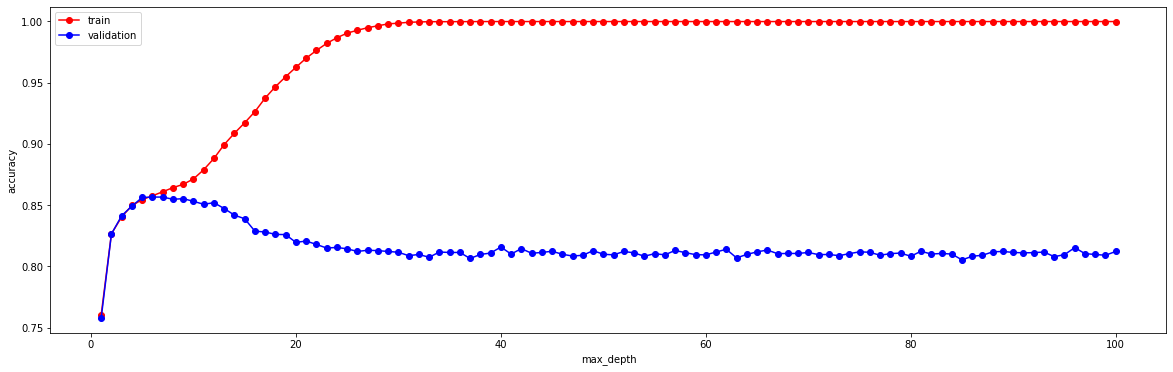

In [28]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(depths, train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
plt.plot(depths, val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [29]:
optimal_depth = np.argmax(val_acc) + 1
optimal_depth

6

Spočítejme **testovací accuracy** pro nejlepší nalezenou hodnotu `max_depth`:

In [30]:
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(Xtrain, ytrain)
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (test): 0.849896


### Grid search: ladění více hyperparameterů

  * Chceme projít hodnoty `max_depth` z intervalu [1, 30] a obě možné hodnoty `criterion`, tj. 60 různých kombinací.
  * Můžeme samozřejmě použít dva vnořené for cykly (což je hrozné) nebo použít `ParameterGrid` balíček.

In [31]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1,31), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)
# pro lepší pochopení:
[param_comb[i] for i in range(43)]

[{'max_depth': 1, 'criterion': 'entropy'},
 {'max_depth': 2, 'criterion': 'entropy'},
 {'max_depth': 3, 'criterion': 'entropy'},
 {'max_depth': 4, 'criterion': 'entropy'},
 {'max_depth': 5, 'criterion': 'entropy'},
 {'max_depth': 6, 'criterion': 'entropy'},
 {'max_depth': 7, 'criterion': 'entropy'},
 {'max_depth': 8, 'criterion': 'entropy'},
 {'max_depth': 9, 'criterion': 'entropy'},
 {'max_depth': 10, 'criterion': 'entropy'},
 {'max_depth': 11, 'criterion': 'entropy'},
 {'max_depth': 12, 'criterion': 'entropy'},
 {'max_depth': 13, 'criterion': 'entropy'},
 {'max_depth': 14, 'criterion': 'entropy'},
 {'max_depth': 15, 'criterion': 'entropy'},
 {'max_depth': 16, 'criterion': 'entropy'},
 {'max_depth': 17, 'criterion': 'entropy'},
 {'max_depth': 18, 'criterion': 'entropy'},
 {'max_depth': 19, 'criterion': 'entropy'},
 {'max_depth': 20, 'criterion': 'entropy'},
 {'max_depth': 21, 'criterion': 'entropy'},
 {'max_depth': 22, 'criterion': 'entropy'},
 {'max_depth': 23, 'criterion': 'entropy'

In [32]:
val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

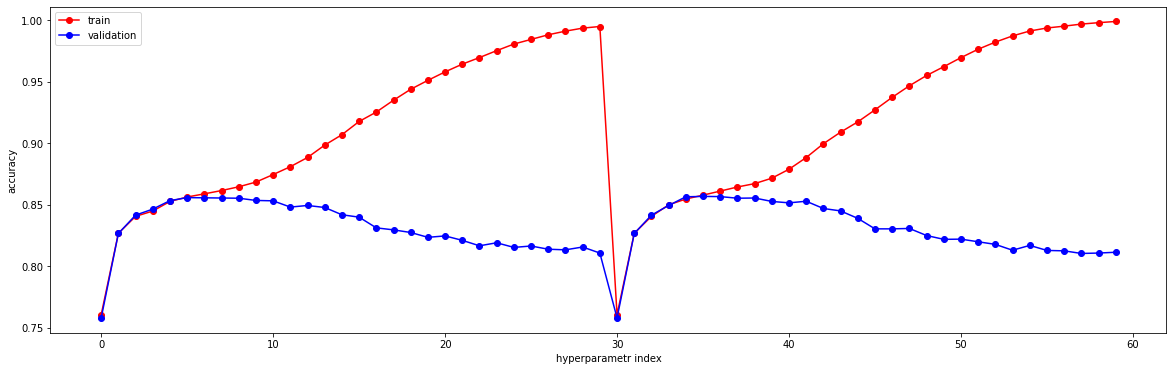

In [33]:
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [34]:
best_params = param_comb[np.argmax(val_acc)]
print(best_params)
print(val_acc[np.argmax(val_acc)])
print(train_acc[np.argmax(val_acc)])

{'max_depth': 6, 'criterion': 'gini'}
0.8566748566748567
0.8577122577122577


In [35]:
dt = DecisionTreeClassifier(**best_params) # TOHOTO ŘÁDKU si všimněte: dvě hvězdišky jsou mocný nástroj
dt.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (train): 0.857712
accuracy score (validation): 0.856675
accuracy score (test): 0.849773


In [36]:
# ukázka operátoru **
def add(a=0, b=0):
    print(a + b)

d = {
    'a': 1,
    'b': -2
}

t = (2, 4)

def add2(c, d):
    print(c + d)

add2(*t)
add(**d)

6
-1


### ÚKOL: naučte strom na datech k Titaniku z minulého cvičení

  * Hyperparametry k tunění si vyberte sami.
  * Rozdělte data ve stejných poměrech a se stejným `random_state` v metode `train_test_split()` jeko výše.

In [37]:
s = pd.Series(['ahoj', 'nazdar', 'cus', 'zdarek'])

# def fce(x):
#     return x + '_a_hany'

# s.apply(lambda x: fce(x + '_ivetko') )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  132 non-null    int64  
 1   Survived     132 non-null    int64  
 2   Pclass       132 non-null    int64  
 3   Name         132 non-null    object 
 4   Sex          132 non-null    object 
 5   FootSize     6 non-null      float64
 6   Age          108 non-null    float64
 7   SibSp        132 non-null    int64  
 8   Parch        132 non-null    int64  
 9   Ticket       132 non-null    object 
 10  Fare         132 non-null    float64
 11  Cabin        29 non-null     object 
 12  Embarked     131 non-null    object 
dtypes: float64(3), int64(5), object(5)
memory usage: 13.5+ KB


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,0,33.0,0,0,0,86.5000,9,2
1,0,3,1,NaN,0,0,81,14.5000,-1,2
2,0,3,1,41.0,0,0,118,7125.0000,-1,2
3,1,3,1,20.0,0,0,38,7.2292,-1,0
4,1,1,0,36.0,1,2,9,120.0000,11,2


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,0,33.0,0,0,0,86.5000,9,2
1,0,3,1,-1.0,0,0,81,14.5000,-1,2
2,0,3,1,41.0,0,0,118,7125.0000,-1,2
3,1,3,1,20.0,0,0,38,7.2292,-1,0
4,1,1,0,36.0,1,2,9,120.0000,11,2


best params  {'max_depth': 6, 'criterion': 'entropy'}
accuracy score (train): 0.972973
accuracy score (validation): 0.840000
accuracy score (test): 0.727273


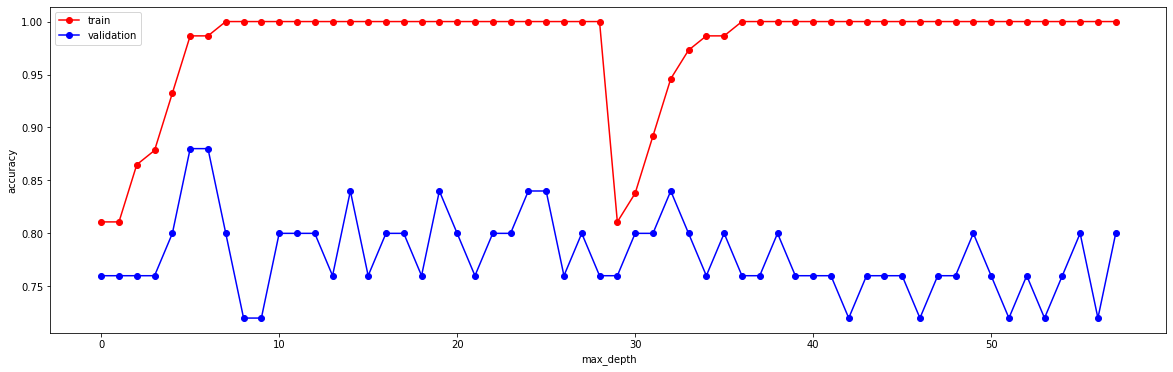

In [38]:
titanic = pd.read_csv('titanic.csv', sep=';')
### sem přijde Váš kód
titanic.info()

# drop nevhodnych priznaku
titanic.drop(columns=["Name", "PassengerId", "FootSize"], inplace=True)

# kategorie
string_cols = titanic.select_dtypes(['object']).columns
titanic[string_cols] = titanic[string_cols].astype('category').apply(lambda x: x.cat.codes)
display(titanic.head())

# nahrazeni nans
titanic = titanic.replace(np.nan, -1)
display(titanic.head())

# rozseknuti na matici priznaku a vektor vysvetlovane promenne
ydata = titanic['Survived']
Xdata = titanic.drop(columns=['Survived'])


# copy paste
rd_seed = 333 # data jsou rozdělována náhodně, v rámci testování je ale dobré mít pevně daný random seed
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed)

param_grid = {
    'max_depth': range(1,30), 
    'criterion': ['entropy', 'gini']
}

param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []

for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
best_params = param_comb[np.argmax(val_acc)]
print('best params ', best_params)
dt = DecisionTreeClassifier(max_depth=best_params['max_depth'], criterion=best_params['criterion'])
dt.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

# Jak vykreslit strom  

In [85]:
simple_data = pd.read_csv('simple_data.csv', sep=';') # data z přednášky
display(simple_data.head(16)) 
dts = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dts.fit(simple_data.iloc[:,1:],simple_data['T'])

,T,F1,F2,F3
0,1,1,0,0
1,1,0,1,1
2,1,1,0,0
3,1,1,1,1
4,0,0,0,1
5,0,0,1,0
6,0,0,0,1
7,0,1,1,0


DecisionTreeClassifier(criterion='entropy', max_depth=2)

[Text(279.0, 453.0, 'F1 <= 0.5\nentropy = 1.0\nsamples = 8\nvalue = [4, 4]\nclass = y[0]'),
 Text(139.5, 271.8, 'F2 <= 0.5\nentropy = 0.811\nsamples = 4\nvalue = [3, 1]\nclass = y[0]'),
 Text(69.75, 90.59999999999997, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = y[0]'),
 Text(209.25, 90.59999999999997, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = y[0]'),
 Text(418.5, 271.8, 'F2 <= 0.5\nentropy = 0.811\nsamples = 4\nvalue = [1, 3]\nclass = y[1]'),
 Text(348.75, 90.59999999999997, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = y[1]'),
 Text(488.25, 90.59999999999997, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = y[0]')]

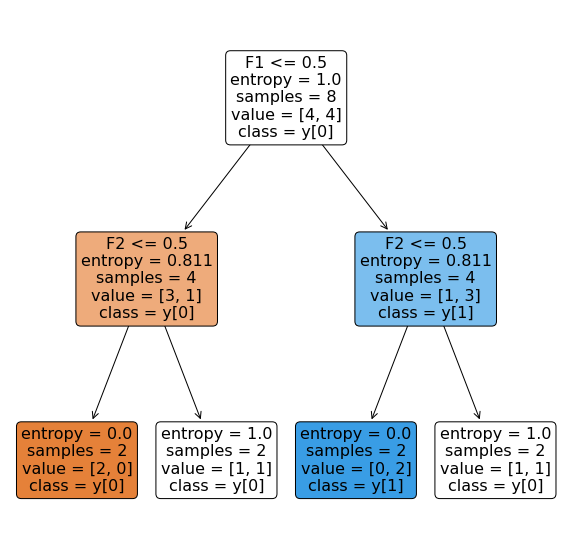

In [86]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(10,10))
plot_tree(dts, filled=True, feature_names=simple_data.iloc[:,1:].columns, class_names=True, rounded=True)


# pro titanik
#plt.figure(figsize=(20,25))
#plot_tree(dt, filled=True, feature_names=Xdata.columns, class_names=["not survived", "survived"], rounded=True)